## <b> Modeling </b> notebook (Nr 3) for <b>Project 2</b> of General Assembly DSIR-0320 
by Martijn de Vries </br>
martijndevries91@gmail.com

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#sklearn imports
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline


## Model 1

In [2]:
#load in the feature engineered training data for model 1
df_model= pd.read_csv('../model_inputs/train_engineered_m1.csv')
df_model.head()

,Id,tot_area,gar_adj_area,yr_built,yr_remod,qual,Overall Cond,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RM,Func_Maj,Func_Min,Func_Mod,Func_Sev,SalePrice
0,109,2204.0,475.000000,1976,2005,6,8,0,0,0,0,0,0,0,0,0,130500
1,544,3035.0,559.000000,1996,1997,7,5,0,0,0,0,0,0,0,0,0,220000
2,153,2114.0,164.452998,1953,2007,5,7,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,457.146484,2006,2007,5,5,0,0,0,0,0,0,0,0,0,174000
4,255,2121.0,323.557931,1900,1993,6,8,0,0,0,0,0,0,0,0,0,138500


In [3]:
X = df_model.drop(columns=['Id', 'SalePrice'])
y = df_model['SalePrice']

In [4]:
#I'll use the term 'val' for this train/test split, so I don't confused with the actual testing data
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)

Before we proceed any further - we'll be evaluating the metrics of different models in this notebook. Let's make a function that returns the r2 score and RMSE of a fit, given a regression object and the X/y training and validation data

In [5]:
def print_metrics(r_obj, X_train, X_val, y_train, y_val, islog=False):
    """
    for a given regression object, and input training/validation data, print out 1) the r2 score, 2) the cross-validation score of the training data, and 
    3) the RMSE for both the training and validation data
    assumes y-values are not log transformed. if islog=True, the log transformation happens within this function
    """
    
    if islog == False:
        train_score = r_obj.score(X_train, y_train)
        val_score = r_obj.score(X_val, y_val)
    elif islog == True:
        train_score = r_obj.score(X_train, np.log(y_train))
        val_score = r_obj.score(X_val, np.log(y_val))
    print(f'The training r2 score is {str(train_score)}')
    print(f'The validation r2 score is {str(val_score)}')

    if islog == False:
        crossval = np.average(cross_val_score(r_obj, X_train, y_train))
    elif islog == True:
        crossval = np.average(cross_val_score(r_obj, X_train, np.log(y_train)))
    
    print(f'The cross validation score is {str(crossval)}')
    print('-'*60)
                
    preds_train = r_obj.predict(X_train)
    preds_val = r_obj.predict(X_val)
    
    #RMSE in dollars
    if islog == False:
        rmse_val =  mean_squared_error(y_val, preds_val, squared=False)
        rmse_train =  mean_squared_error(y_train, preds_train, squared=False)
    elif islog == True:
        rmse_val =  mean_squared_error(y_val, np.exp(preds_val), squared=False)
        rmse_train =  mean_squared_error(y_train, np.exp(preds_train), squared=False)
        
    print(f'The training RMSE score is {str(rmse_train)}')
    print(f'The validation RMSE score is {str(rmse_val)}')
    
    return

In [6]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [7]:
print_metrics(lr, X_train, X_val, y_train, y_val)

The training r2 score is 0.8364646924759667
The validation r2 score is 0.8322937626582069
The cross validation score is 0.8307021724801407
------------------------------------------------------------
The training RMSE score is 31942.692071990143
The validation RMSE score is 32638.840088824727


The model is not overfit, given the good agreement in scores. Let's make a residual plot as well:

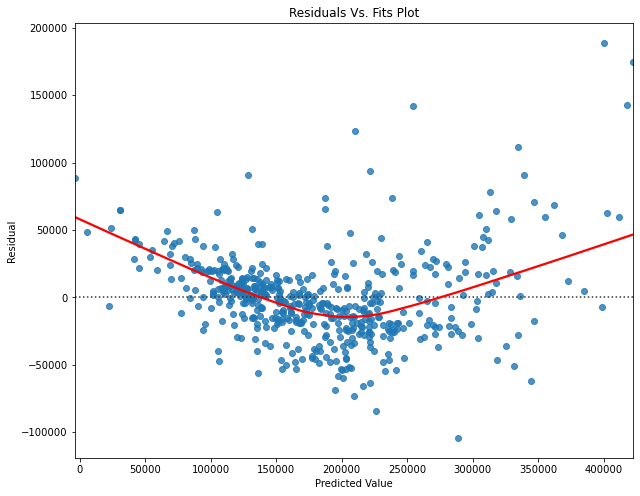

In [8]:
preds_val = lr.predict(X_val)
resids = y_val - preds_val
plt.figure(figsize=(10,8))
sns.residplot(x = preds_val,  y = resids, lowess = True, 
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

It seems that the linearity and equal variance of errors assumptions are definitely violated. This residual plot could be a lot better.

In the feature engineering notebook, we saw that it seems that at least for some predictor variables, the relationship seems more linear to log(SalePrice) rather than SalePrice. What if I fit using that instead?

In [9]:
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression()

In [10]:
print_metrics(lr, X_train, X_val, y_train, y_val, islog=True)

The training r2 score is 0.8918071308186171
The validation r2 score is 0.8619414346911233
The cross validation score is 0.8878700070800246
------------------------------------------------------------
The training RMSE score is 25970.4825715732
The validation RMSE score is 25859.827882086647


This seems to improve thigs a little bit!

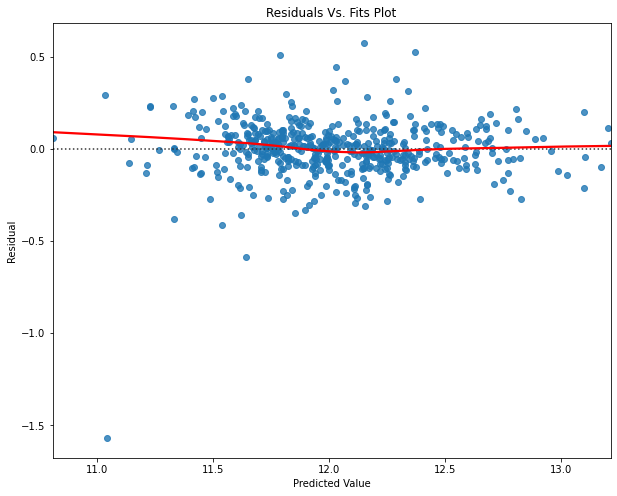

In [11]:
preds_val = lr.predict(X_val)
resids = np.log(y_val) - preds_val
plt.figure(figsize=(10,8))
sns.residplot(x = preds_val,
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

That looks a lot better overall, but there are some serious overpredictions on the lower end. Which I guess makes sense to some degree - if a house costs eg. 40,000 dollars but our model predicts 100,000 dollars, we are going to be off by a lot in logspace. However, in the end we care about the RMSE of the y transformed back to actual dollars. So while that outlier looks bad in logspace, it's not going to look nearly as bad in linear space.

In [12]:
def make_kaggle_df(df, r_obj, islog=False):
    """
    With an input dataframe and sklearn regression object
    construct a dataframe for Kaggle submission
    """
    X_test = df.drop(columns=['Id'])
    ids = df['Id']
    
    preds = r_obj.predict(X_test)
    if islog == True:
        preds = np.exp(preds)
    
    d = {'SalePrice': preds}
    kaggle_m1 = pd.DataFrame(data=d, index=ids)
    return kaggle_m1

In [13]:
#Make a Kaggle submission
df_model_test= pd.read_csv('../model_inputs/test_engineered_m1.csv')
kaggle_m1 = make_kaggle_df(df_model_test, lr, islog=True)
kaggle_m1.to_csv('../datasets/submission_lin_m1.csv')

## Model 2

What about my more complex model? Will it perform better?

In [14]:
#load in the feature engineered training data for model 2
df_model2= pd.read_csv('../model_inputs/train_engineered_m2.csv')
df_model2.head()

,Id,tot_area,gar_adj_area,yr_built,yr_remod,qual,tot_rooms_abv,Full Bath,adj_mas_vnr_area,adj_fireplace,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice
0,109,2204.0,475.000000,1976,2005,6,6,2,289.0,0.0,...,0,0,0,1,0,0,0,0,0,130500
1,544,3035.0,559.000000,1996,1997,7,8,2,132.0,1.0,...,0,0,0,0,1,0,0,0,0,220000
2,153,2114.0,164.452998,1953,2007,5,5,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,457.146484,2006,2007,5,7,2,0.0,0.0,...,0,0,0,0,0,0,0,1,0,174000
4,255,2121.0,323.557931,1900,1993,6,6,2,0.0,0.0,...,0,0,0,0,1,0,0,0,0,138500


In [15]:
X = df_model2.drop(columns=['Id', 'SalePrice'])
y = df_model2['SalePrice']

In [16]:
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [17]:
print_metrics(lr, X_train, X_val, y_train, y_val)

The training r2 score is 0.8754340113536129
The validation r2 score is 0.8717136850496329
The cross validation score is 0.8652569124624929
------------------------------------------------------------
The training RMSE score is 27878.248728875817
The validation RMSE score is 28546.32947145986


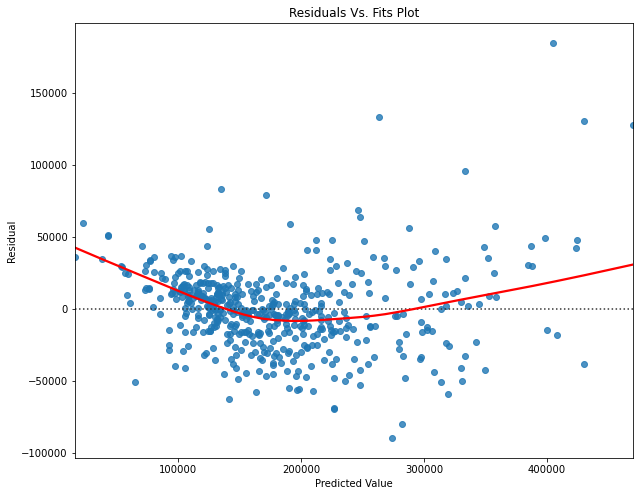

In [18]:
preds_val = lr.predict(X_val)
resids = y_val - preds_val
plt.figure(figsize=(10,8))
sns.residplot(x = preds_val,  y = resids, lowess = True, 
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

Yeah, that still looks bad. Let's try a log transform again

In [19]:
lr.fit(X_train, np.log(y_train))

LinearRegression()

In [20]:
print_metrics(lr, X_train, X_val, y_train, y_val, islog=True)

The training r2 score is 0.9013450294642926
The validation r2 score is 0.8583798602876096
The cross validation score is 0.8906485381679877
------------------------------------------------------------
The training RMSE score is 23746.581375341066
The validation RMSE score is 23644.28770928987


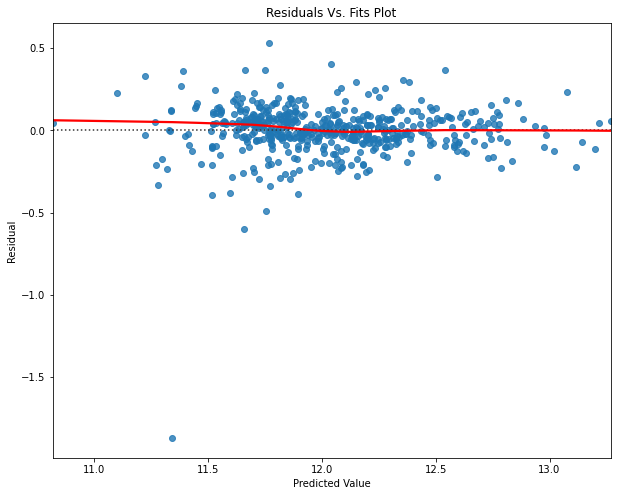

In [21]:
preds_val = lr.predict(X_val)
resids = np.log(y_val) - preds_val
plt.figure(figsize=(10,8))
sns.residplot(x = preds_val,
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

To make this more interpretable, let's also include make a actual vs predicted values plot (in dollars)

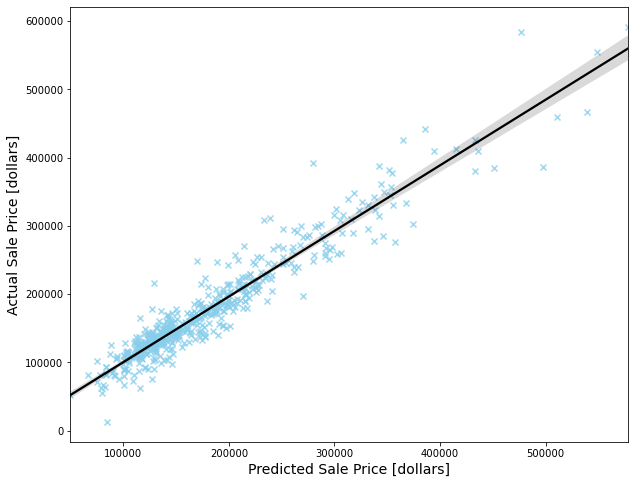

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=np.exp(preds_val), y=y_val, marker='x', color='skyblue', line_kws={'color':'black'})
ax.set_xlabel('Predicted Sale Price [dollars]', fontsize=14)
ax.set_ylabel('Actual Sale Price [dollars]', fontsize=14)
plt.show()

In [23]:
#Make another Kaggle submission with the more complex model
df_model_test= pd.read_csv('../model_inputs/test_engineered_m2.csv')
kaggle_m2 = make_kaggle_df(df_model_test, lr, islog=True)
kaggle_m2.to_csv('../datasets/submission_lin_m2.csv')

What if we try a ridge regression for this model input?

In [24]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, np.log(y_train))

Ridge()

In [25]:
print_metrics(ridge, X_train, X_val, y_train, y_val, islog=True)

The training r2 score is 0.9006851980259416
The validation r2 score is 0.856720306402793
The cross validation score is 0.8908062100282516
------------------------------------------------------------
The training RMSE score is 23797.84491877722
The validation RMSE score is 23822.549415692814


In [26]:
#Make another Kaggle submission with the model 2 ridge
df_model_test= pd.read_csv('../model_inputs/test_engineered_m2.csv')
kaggle_m2 = make_kaggle_df(df_model_test, ridge, islog=True)
kaggle_m2.to_csv('../datasets/submission_ridge_m2.csv')

## Model 3

In [27]:
#load in the feature engineered training data for model 3
#this model 
df_model3= pd.read_csv('../model_inputs/train_engineered_m3.csv')
df_model3.head()

,Id,tot_area,Garage Area,yr_built,yr_remod,qual,tot_rooms_abv,Full Bath,mas_vnr_area,fireplaces,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice
0,109,2204.0,475.0,1976,2005,6,6,2,289.0,0,...,0,0,0,1,0,0,0,0,0,130500
1,544,3035.0,559.0,1996,1997,7,8,2,132.0,1,...,0,0,0,0,1,0,0,0,0,220000
2,153,2114.0,246.0,1953,2007,5,5,1,0.0,0,...,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,400.0,2006,2007,5,7,2,0.0,0,...,0,0,0,0,0,0,0,1,0,174000
4,255,2121.0,484.0,1900,1993,6,6,2,0.0,0,...,0,0,0,0,1,0,0,0,0,138500


In [28]:
X = df_model3.drop(columns=['Id', 'SalePrice'])
y = df_model3['SalePrice']
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression()

In [29]:
print_metrics(lr, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9007198040259546
The validation r2 score is 0.8538449127640642
The cross validation score is 0.8903744234120443
------------------------------------------------------------
The training RMSE score is 23873.000251982732
The validation RMSE score is 23534.982762563006


It seems that this model, without the 'adjustment' calculations, actually scores just as well as model 2

In [34]:
#Make another Kaggle submission with the more complex model
df_model_test= pd.read_csv('../model_inputs/test_engineered_m3.csv')
kaggle_m3 = make_kaggle_df(df_model_test, lr, islog=True)
kaggle_m3.to_csv('../datasets/submission_lin_m3.csv')

In [31]:
#transform data to see if that makes it better
scaler = StandardScaler()
pipe = make_pipeline(MinMaxScaler(), Ridge())
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge())])

In [32]:
print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.899484827937777
The validation r2 score is 0.8517567431808323
The cross validation score is 0.8892941078953832
------------------------------------------------------------
The training RMSE score is 24091.367124314133
The validation RMSE score is 23663.856732105076


In [36]:
#Make another Kaggle submission with the model 3 ridge
df_model_test= pd.read_csv('../model_inputs/test_engineered_m3.csv')
kaggle_m3 = make_kaggle_df(df_model_test, pipe, islog=True)
kaggle_m3.to_csv('../datasets/submission_ridge_m3.csv')

## Model 4

In [71]:
#load in the feature engineered training data for model 4
#this model 
df_model4= pd.read_csv('../model_inputs/train_engineered_m4.csv')
df_model4.head()

,Id,tot_area,Garage Area,yr_built,yr_remod,qual,tot_rooms_abv,Full Bath,mas_vnr_area,fireplaces,...,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,SalePrice
0,109,2204.0,475.0,1976,2005,6,6,2,289.0,0,...,1,0,0,0,0,0,0,0,1,130500
1,544,3035.0,559.0,1996,1997,7,8,2,132.0,1,...,0,1,0,0,0,0,0,0,1,220000
2,153,2114.0,246.0,1953,2007,5,5,1,0.0,0,...,0,0,0,0,0,0,0,0,1,109000
3,318,1828.0,400.0,2006,2007,5,7,2,0.0,0,...,0,0,0,0,1,0,0,0,0,174000
4,255,2121.0,484.0,1900,1993,6,6,2,0.0,0,...,0,1,0,0,0,0,0,0,0,138500


In [90]:
li = df_model4[df_model4['SalePrice'] < 2e4].index
df_model4.drop(index=li, inplace=True)

In [91]:
X = df_model4.drop(columns=['Id', 'SalePrice'])
y = df_model4['SalePrice']
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=50)
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression()

In [92]:
print_metrics(lr, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9163460173668704
The validation r2 score is 0.9050218588981083
The cross validation score is 0.9042869094198185
------------------------------------------------------------
The training RMSE score is 22500.269485167802
The validation RMSE score is 21554.57311538695


In [93]:
#transform data to see if that makes it better
pipe = make_pipeline(StandardScaler(), Ridge())
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [94]:
print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9163457255355738
The validation r2 score is 0.9050438718152715
The cross validation score is 0.9043042683862138
------------------------------------------------------------
The training RMSE score is 22500.958670260632
The validation RMSE score is 21546.722417181056


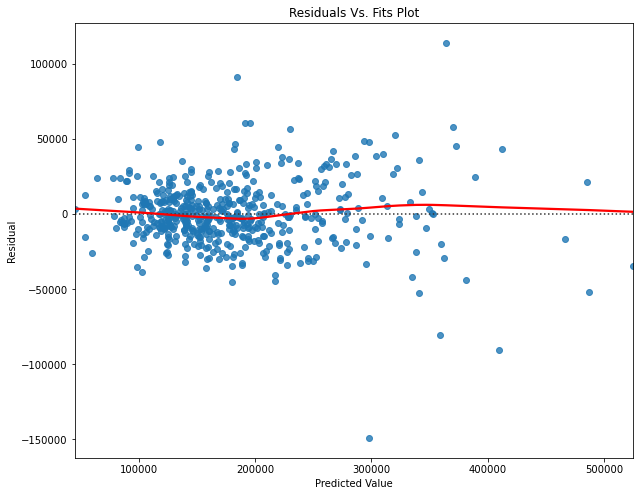

In [96]:
preds_val = lr.predict(X_val)
resids = y_val - np.exp(preds_val)
plt.figure(figsize=(10,8))
sns.residplot(x = np.exp(preds_val),
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

In [87]:
#Make another Kaggle submission with the model 4 ridge
df_model_test= pd.read_csv('../model_inputs/test_engineered_m4.csv')
kaggle_m4 = make_kaggle_df(df_model_test, pipe, islog=True)
kaggle_m4.to_csv('../datasets/submission_ridge_m4.csv')